
## The Exercise

Your goal is to compare the performance of two styles of transfer learning on two different base models. This means you'll implement 4 examples of transfer learning in total. First, import the built in CIFAR100 dataset, then select one of the built in models from Keras (MobileNetV2 for example) to serve as your base model and follow these steps:

### Part 1: Fixed Feature Extraction

* Import this model using the `imagenet` weights, and `include_top=False`.
* Run the CIFAR 100 test and training data through this model and save the resulting features.
  * An example of this can be found in 03-transfer-learning.ipynb directly under the "Transfer Learning Tips and Pitfalls" header.
* Create a classification network for the CIFAR 100 dataset which will:
  * Accept as input the result of our pretrained model (i.e. the features you just saved)
  * Produce as output a classification for the CIFAR100 dataset.
* Train your classification network on the saved features.
* Plot your results.

### Part 2: Partially Frozen Transfer Learning

* Import this model using the `imagenet` weights, and `include_top=False`.
* Freeze at least the first half of all convolutional layers in that model.
* Add a classification section to the model corresponding to the CIFAR100 dataset.
* Train this model on the CIFAR100 dataset.
* Plot your results

### Part 3: Repeat

Repeat the previous two sections with a different base model (Xception for example instead of MobileNetV2), and compare your results. Make a note especially of the difference in training time—some of these models are significantly more complex.

In [ ]:
# this should look familiar from the previous labs. 
# We could choose any of the pre-built nets here instead. 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# This is a new built in dataset that we haven't seen before.
# It is 60,000 (50k training, 10k test) small (32x32) RGB images 
# classified into 100 classes:
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Constant number of labels, square image shape
NUM_CLASSES = 100
IMAGE_SIZE = 96

# FOR DISPLAY PURPOSES
unprocessed_training_images = x_train
unprocessed_training_labels = y_train

# Because the network we're fine-tuning (MobileNetV2) has several pooling layers
# the smallest image it can process is 96x96, these images are 32x32. To fix this
# we are manually rescaling all the images using scipy. We are also applying the 
# MobileNetV2 preprocess_input function here. 
def adjust_input_image(rgb_data):
    adjusted = preprocess_input(rgb_data)
    
    # Scales width and height by 3, leaves color channels at original scale
    adjusted = ndimage.zoom(adjusted, (3, 3, 1), order=0)

    return adjusted

x_train = np.array([adjust_input_image(x) for x in x_train])
x_test = np.array([adjust_input_image(x) for x in x_test])

# And we still need to one-hot encode the labels as usual
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

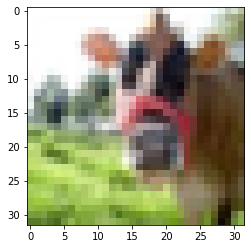

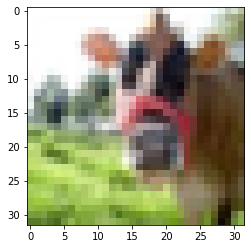

In [2]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(unprocessed_training_images[0])
plt.show()

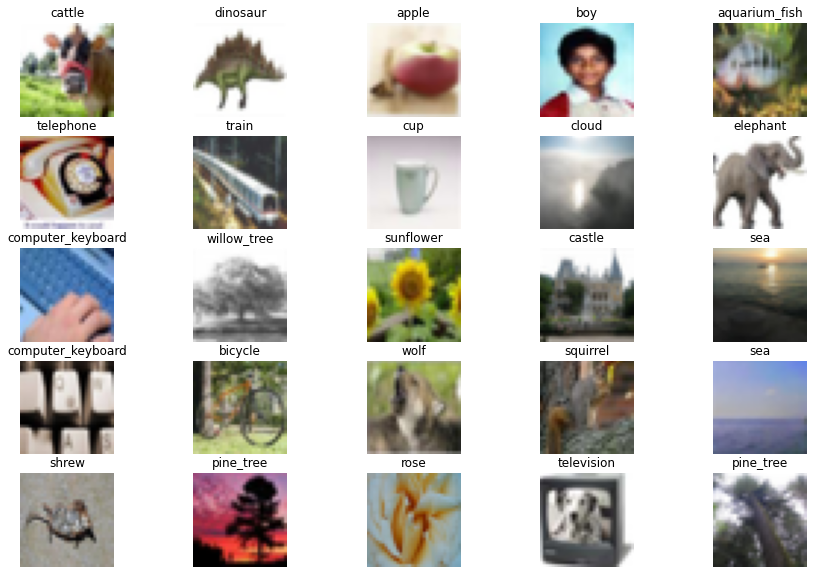

In [3]:
# Some of these are genuinely challenging... 
label_map = [
    'apple', # id 0
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm'
]

plt.figure(figsize=(15, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.axis('off')
    ax.set_title(label_map[unprocessed_training_labels[i][0]])
    plt.imshow(unprocessed_training_images[i])

In [4]:
# This should look familiar from previous labs.
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

In [8]:
# The first way we'll do transfer learning REALLY saves time, but
# only works if you don't want to fine tune any of the layers 
# from the original network. What we can do instead is memorize
# the output of the base network, since it won't be changing,
# and then repeatedly train on those outputs and the training labels

# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unlike before, we're going to just run the images through this base layer once
# This takes awhile, we're essentially doing a round of evaluation on both datasets.
# And we'll save them incase we want to experiment with different models to transfer
# on top of these.
training_features = base_model.predict(x_train)
np.savez('MobileNetV2_features_train', features=training_features)

test_features = base_model.predict(x_test)
np.savez('MobileNetV2_features_test', features=test_features)

c:\users\sentinal\.virtualenvs\intro-to-deep-learning-san2vixs\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 3s 0us/step


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Layers go from 0-154
#   initial=0-9
#   block1 = 10-18
#   block2 = 19-27
#   block3 = 28-36
#   block4 = 37-45
#   block5 = 46-54
#   block6 = 55-63
#.  block7 = 64-72
#   block8 = 73-81
#.  block9 = 81-90
#   block10= 91-98
#   block11= 99-107
#.  block12= 108-116
#.  block13= 117-125
#   block14= 126-134
#.  block15= 135-143
#.  block16= 144-151
#.  final_conv = 152, 
#   conv_bn 153
#   out_relu = 154
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 23s 568us/sample - loss: 4.5047 - accuracy: 0.0239 - val_loss: 4.4298 - val_accuracy: 0.0307
Epoch 2/20
40000/40000 [==============================] - 20s 502us/sample - loss: 4.4024 - accuracy: 0.0355 - val_loss: 4.3933 - val_accuracy: 0.0382
Epoch 3/20
40000/40000 [==============================] - 21s 529us/sample - loss: 4.3626 - accuracy: 0.0403 - val_loss: 4.3791 - val_accuracy: 0.0385
Epoch 4/20
40000/40000 [==============================] - 21s 513us/sample - loss: 4.3376 - accuracy: 0.0443 - val_loss: 4.3736 - val_accuracy: 0.0416
Epoch 5/20
40000/40000 [==============================] - 23s 570us/sample - loss: 4.3148 - accuracy: 0.0479 - val_loss: 4.3625 - val_accuracy: 0.0448
Epoch 6/20
40000/40000 [==============================] - 23s 578us/sample - loss: 4.2961 - accuracy: 0.0508 - val_loss: 4.3650 - val_accuracy: 0.0466
Epoch 7/20
40000/40000 [====================

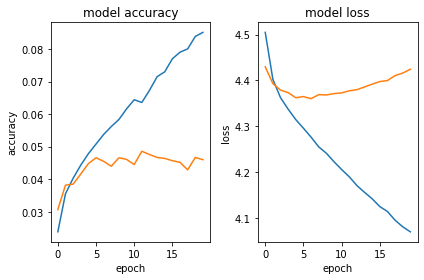

Test loss: 4.41
Test accuracy: 0.0431


In [11]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=training_features.shape[1:]))

# Note from the summary, this will result in 1280 nodes, let's use the classic "squeeze" and add dropout
model.add(Dense(units=640, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(units=320, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_features, y_train, batch_size=128, epochs=20, validation_split=0.2, verbose=True)

plot_training_history(history, model)
loss, accuracy = model.evaluate(test_features, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')




In [17]:

def transfer_from_mobilenet(optimizer, freeze_first_n_layers, batch_size, epochs):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    # We'll use the same "squeeze" w/ dropout structure from above...
    # We have to use the "functional" API now, which is why we're not using model.add
    old_top = base_model.output
    old_top = GlobalAveragePooling2D()(old_top)
    old_top = Dense(units=640, activation='relu')(old_top)
    old_top = Dropout(rate=0.4)(old_top)
    old_top = Dense(units=320, activation='relu')(old_top)
    old_top = Dropout(rate=0.2)(old_top)
    new_top = Dense(NUM_CLASSES, activation='softmax')(old_top)
    
    model = Model(inputs=base_model.input, outputs=new_top)

    for layer in model.layers[:freeze_first_n_layers]:
        layer.trainable = False

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=True)
    
    return history, model

Transfer learning with sgd, 0 Will save as:  sgd_0.h5

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 746s 19ms/sample - loss: 4.6820 - accuracy: 0.0169 - val_loss: 4.5944 - val_accuracy: 0.0198
Epoch 2/5
40000/40000 [==============================] - 888s 22ms/sample - loss: 4.4767 - accuracy: 0.0385 - val_loss: 4.5805 - val_accuracy: 0.0209
Epoch 3/5
40000/40000 [==============================] - 806s 20ms/sample - loss: 4.2397 - accuracy: 0.0736 - val_loss: 4.5353 - val_accuracy: 0.0310
Epoch 4/5
40000/40000 [==============================] - 799s 20ms/sample - loss: 3.9774 - accuracy: 0.1124 - val_loss: 4.5268 - val_accuracy: 0.0329
Epoch 5/5
40000/40000 [==============================] - 816s 20ms/sample - loss: 3.7052 - accuracy: 0.1486 - val_loss: 4.5193 - val_accuracy: 0.0505


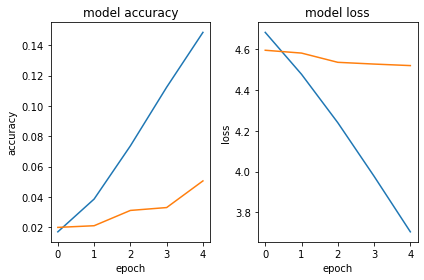

Test loss: 4.52
Test accuracy: 0.0524
Transfer learning with sgd, 72 Will save as:  sgd_72.h5



c:\users\sentinal\.virtualenvs\intro-to-deep-learning-san2vixs\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 654s 16ms/sample - loss: 4.6130 - accuracy: 0.0239 - val_loss: 5.0361 - val_accuracy: 0.0106
Epoch 2/5
40000/40000 [==============================] - 668s 17ms/sample - loss: 4.3642 - accuracy: 0.0564 - val_loss: 4.6669 - val_accuracy: 0.0130
Epoch 3/5
40000/40000 [==============================] - 649s 16ms/sample - loss: 4.1727 - accuracy: 0.0882 - val_loss: 4.6452 - val_accuracy: 0.0151
Epoch 4/5
40000/40000 [==============================] - 660s 17ms/sample - loss: 3.9470 - accuracy: 0.1262 - val_loss: 4.5871 - val_accuracy: 0.0178
Epoch 5/5
40000/40000 [==============================] - 678s 17ms/sample - loss: 3.6616 - accuracy: 0.1757 - val_loss: 4.5879 - val_accuracy: 0.0150


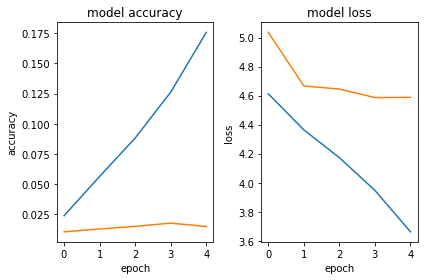

Test loss: 4.59
Test accuracy: 0.0147
Transfer learning with <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001E5780F3C08>, 0 Will save as:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001E5780F3C08>_0.h5



c:\users\sentinal\.virtualenvs\intro-to-deep-learning-san2vixs\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 854s 21ms/sample - loss: 4.6444 - accuracy: 0.0253 - val_loss: 4.6219 - val_accuracy: 0.0183
Epoch 2/5
40000/40000 [==============================] - 709s 18ms/sample - loss: 4.1464 - accuracy: 0.0939 - val_loss: 4.5257 - val_accuracy: 0.0424
Epoch 3/5
40000/40000 [==============================] - 691s 17ms/sample - loss: 3.6357 - accuracy: 0.1640 - val_loss: 4.3344 - val_accuracy: 0.0721
Epoch 4/5
40000/40000 [==============================] - 665s 17ms/sample - loss: 3.2042 - accuracy: 0.2328 - val_loss: 4.1006 - val_accuracy: 0.1053
Epoch 5/5
40000/40000 [==============================] - 616s 15ms/sample - loss: 2.9117 - accuracy: 0.2804 - val_loss: 3.7751 - val_accuracy: 0.1679


OSError: Unable to create file (unable to open file: name = 'C:/Users/Sentinal/Desktop/AaronBranch/intro-to-deep-learning/04-convolutional-neural-networks/afile\<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001E5780F3C08>_0.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [22]:
from itertools import product
from tensorflow.keras.optimizers import Adam
import os # for saving with paths. 

# These experiments took *several hours* to run originally.
# Saving the model after an experiment is a good idea, then you
# can experiment further with promising models, without rerunning
# entier experiments.
save_directory = 'C:/Users/Sentinal/Desktop/AaronBranch/intro-to-deep-learning/04-convolutional-neural-networks/afile'



# More agressive optimizers like adam can result in overfitting
# We should watch for that in our results.
optimizers = [
    'sgd',
    Adam(lr=0.0001)  # Slower than normal learning rate. 
]

# Note: experimentally freezing only the first 2 blocks
# resulted in much slower performance, though for SGD freezing 
# only the first block did achieve 50% accuracy on test data 
#   initial=0-9
#   block1 = 10-18
#   block2 = 19-27
#   block3 = 28-36
#   block4 = 37-45
#   block5 = 46-54
#   block6 = 55-63
#.  block7 = 64-72
#   block8 = 73-81
freeze_layer_counts = [
    0,   # Up through block 14 frozen
    72    # Up through block 15 frozen
    
    # If we were to set a value here to 154, it would freeze all the original layers
    # which can be quite successful, but we can make training much faster using a 
    # different tactic to freeze all the original layers as demonstrated above
]

# This takes a LOOOOONNNNNNNGGGGG time, don't re-run it unless you're prepared to wait. 
for optimizer, freeze_first_n_layers in product(optimizers, freeze_layer_counts):
    saved_name = f'{optimizer}_{freeze_first_n_layers}.h5'
    print(f'Transfer learning with {optimizer}, {freeze_first_n_layers}', "Will save as: ", saved_name)
    print()

    history, model = transfer_from_mobilenet(optimizer, freeze_first_n_layers, 128, 5)
    model.save(os.path.join(save_directory, saved_name))
    plot_training_history(history, model)
    
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    

In [23]:
# The first way we'll do transfer learning REALLY saves time, but
# only works if you don't want to fine tune any of the layers 
# from the original network. What we can do instead is memorize
# the output of the base network, since it won't be changing,
# and then repeatedly train on those outputs and the training labels

# Like before, we grab a pretrained model with include_top=False
base_model = Xception(include_top=False, weights='imagenet',  input_shape=(32, 32, 3)) 

# Unlike before, we're going to just run the images through this base layer once
# This takes awhile, we're essentially doing a round of evaluation on both datasets.
# And we'll save them incase we want to experiment with different models to transfer
# on top of these.
training_features = base_model.predict(x_train)
np.savez('MobileNetV2_features_train', features=training_features)

test_features = base_model.predict(x_test)
np.savez('MobileNetV2_features_test', features=test_features)

NameError: name 'Xception' is not defined

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Layers go from 0-154
#   initial=0-9
#   block1 = 10-18
#   block2 = 19-27
#   block3 = 28-36
#   block4 = 37-45
#   block5 = 46-54
#   block6 = 55-63
#.  block7 = 64-72
#   block8 = 73-81
#.  block9 = 81-90
#   block10= 91-98
#   block11= 99-107
#.  block12= 108-116
#.  block13= 117-125
#   block14= 126-134
#.  block15= 135-143
#.  block16= 144-151
#.  final_conv = 152, 
#   conv_bn 153
#   out_relu = 154
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
base_model.summary()

In [ ]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=training_features.shape[1:]))

# Note from the summary, this will result in 1280 nodes, let's use the classic "squeeze" and add dropout
model.add(Dense(units=640, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(units=320, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_features, y_train, batch_size=128, epochs=20, validation_split=0.2, verbose=True)

plot_training_history(history, model)
loss, accuracy = model.evaluate(test_features, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
